In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = ["clean_trace"]


df = pd.read_csv(DF_PREPROC_FILE)
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
# print(traces["syll_labels"].shape)

SAMPLING_RATE = 48_000/8

%load_ext autoreload
%autoreload 2

## Define a model

In [2]:
from keras.layers import Conv1D, Dense, Flatten, AveragePooling1D
from keras.models import Sequential

# Use different conv layers
def build_model(input_shape, n_categories,
                
                # Convolution parameters
                conv_filter_sizes = [16, 8],
                conv_kernel_sizes = [5, 3],
                conv_pool_sizes = [2, None],
                
                # Dense parameters
                n_dense_layers=2,
                dense_nodes=256,
                **kwargs):
    
    n_conv_blocks = len(conv_filter_sizes)

    model = Sequential()
    
    # Conv1d + temporal average pooling
    for block_id in range(n_conv_blocks):
        conv = Conv1D(conv_filter_sizes[block_id], conv_kernel_sizes[block_id], 
                      input_shape=input_shape,
                      activation="relu", 
                      name=f"conv_{block_id}",
#                         padding="valid"
                     )
        
        
        model.add(conv)
        if block_id < n_conv_blocks - 1:
            pool = AveragePooling1D(pool_size=conv_pool_sizes[block_id], name=f"avg_pooling_{block_id}")
            model.add(pool)
            
    # Flattens stuff :3
    model.add(Flatten())
    
    # A good dose of Dense layers never hurted anybody
    for block_id in range(n_dense_layers):
        model.add(Dense(dense_nodes, 
                        activation="relu", 
                        name=f"dense_{block_id}"))
    
    # Let the garbage out
    model.add(Dense(n_categories, 
                    activation="softmax",
                    name="output"))
    
    model.compile(optimizer="adam", 
                  loss="sparse_categorical_crossentropy", 
                  metrics=['accuracy'])
    return model

2023-07-02 12:58:00.138920: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-02 12:58:00.273433: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-02 12:58:00.276582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 12:58:01.989807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Tuning (for prediction of almost all categories)

### Prepare the different resolutions

In [3]:
# In the tuning the spectral resolution is optimized too
from djanloo_fourier import FixedResolutionSTFTransformer
from tensorflow.keras.preprocessing.sequence import pad_sequences

STFT_dict = dict()
possible_resolutions = [90, 100, 110, 115]
for res in possible_resolutions:
    ## Really gets the dataset of STFTs
    fixedtr = FixedResolutionSTFTransformer(n_spectral_points=res,
                                            pad_spectra=False,
                                            verbose=True)
    
    # Gets STFTs
    STFTs = fixedtr.transform(traces["clean_trace"])
    STFT_dict[res] = pad_sequences(STFTs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:11<00:00, 215.66it/s]


In [4]:
from sklearn.preprocessing import LabelEncoder

# Gets labels
enc = LabelEncoder()
labels = np.array([f"{s}{e}{vc}" for s,e,vc in zip(df.sex, df.emotion, df.vocal_channel)])
y = enc.fit_transform(labels)

### Define the objective function to maximise

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def objective(trial, train_idxs, val_idxs):
    global y, possible_resolutions
    
    epochs=trial.suggest_int('epochs',15,40)
    
    # Gets the data
    X = STFT_dict[trial.suggest_categorical("resolution", choices=possible_resolutions)]
    
    # Builds the convolutional parameters
    n_conv_blocks = trial.suggest_int('n_conv_blocks', 1, 3)
    filter_sizes, kernel_sizes, pool_sizes = [], [], []  
    for block_id in range(n_conv_blocks):
        filter_sizes.append(trial.suggest_int(f'filters_{block_id}', 2, 16))
        kernel_sizes.append(trial.suggest_int(f'kernels_{block_id}', 3, 9))
        pool_sizes.append(trial.suggest_int(f'pool_{block_id}', 2, 8))

    
    ## Concerning the model ...
    pars = dict(## Conv stuff 
                conv_filter_sizes=filter_sizes, 
                conv_kernel_sizes=kernel_sizes, 
                conv_pool_sizes=pool_sizes,
                
                ## Dense stuff
                n_dense_layers=trial.suggest_int('n_dense_layers', 1, 3), 
                dense_nodes=trial.suggest_int('dense_nodes', 16, 512)
               )
    print(f"running model having {pars} with SpRes = {fixedtr.n_spectral_points} for epochs = {epochs}")
    
    model = build_model(X.shape[1:], len(np.unique(y)), **pars)
    model.fit(
                    X[train_idxs], y[train_idxs], 
                    epochs=epochs,
                    batch_size=trial.suggest_int('batch_size', 16, 32),
                    verbose=False
                    )
    
    ## Estimate accuracy
    y_pred = np.argmax(model.predict(X[val_idxs], verbose=False), axis=1)
    acc = accuracy_score(y[val_idxs], y_pred)
    
    return acc

In [6]:
## Splits the dataset
idxs = np.arange(len(df))
np.random.shuffle(idxs)
train_idxs, val_idxs, test_idxs = np.split(idxs, (len(df)*np.array([0.7, 0.8])).astype(int))

In [7]:
import optuna
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective(trial, train_idxs, val_idxs)
study.optimize(trial_function, n_trials=1, n_jobs=1, catch=ValueError)

[I 2023-07-02 12:58:42,352] A new study created in memory with name: no-name-118db4cf-ea09-4f5b-bf64-833340812565


running model having {'conv_filter_sizes': [11, 11], 'conv_kernel_sizes': [5, 7], 'conv_pool_sizes': [5, 7], 'n_dense_layers': 1, 'dense_nodes': 394} with SpRes = 115 for epochs = 23


2023-07-02 12:58:42.701960: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 207979200 exceeds 10% of free system memory.
[I 2023-07-02 12:59:20,429] Trial 0 finished with value: 0.363265306122449 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 11, 'kernels_1': 7, 'pool_1': 7, 'n_dense_layers': 1, 'dense_nodes': 394, 'batch_size': 21}. Best is trial 0 with value: 0.363265306122449.


## Results

In [8]:
best_params_allclass = study.best_params.copy()

# Retrieves best parameters form the dict and saves them as a list
best_params_allclass["conv_filter_sizes"] = []
best_params_allclass["conv_kernel_sizes"] = []
best_params_allclass["conv_pool_sizes"] = []

for key in np.sort(list(study.best_params.keys())):
    if "filter" in key:
        best_params_allclass["conv_filter_sizes"].append(study.best_params[key])
    if "kernel" in key:
        best_params_allclass["conv_kernel_sizes"].append(study.best_params[key])
    if "pool" in key:
        best_params_allclass["conv_pool_sizes"].append(study.best_params[key])

print("for all-class best is", best_params_allclass)
        
        
        
X = STFT_dict[best_params_allclass["resolution"]]

cnn = build_model(X.shape[1:], len(np.unique(y)), **best_params_allclass)
cnn.summary()

# Train on train+validation
final_train_idxs = np.concatenate((train_idxs, val_idxs))

cnn.fit(X[final_train_idxs], 
        y[final_train_idxs], 
        epochs=best_params_allclass["epochs"], 
        batch_size=best_params_allclass["batch_size"])

for all-class best is {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 11, 'kernels_1': 7, 'pool_1': 7, 'n_dense_layers': 1, 'dense_nodes': 394, 'batch_size': 21, 'conv_filter_sizes': [11, 11], 'conv_kernel_sizes': [5, 7], 'conv_pool_sizes': [5, 7]}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv1D)             (None, 299, 11)           5511      
                                                                 
 avg_pooling_0 (AveragePooli  (None, 59, 11)           0         
 ng1D)                                                           
                                                                 
 conv_1 (Conv1D)             (None, 53, 11)            858       
                                                                 
 flatten_1 (Flatten)         (None, 583)               0         
    

2023-07-02 12:59:20.970407: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 237673200 exceeds 10% of free system memory.


94/94 [==============================] - 4s 27ms/step - loss: 2.6771 - accuracy: 0.2035
Epoch 2/23
94/94 [==============================] - 2s 26ms/step - loss: 1.9431 - accuracy: 0.3335
Epoch 3/23
94/94 [==============================] - 2s 22ms/step - loss: 1.6812 - accuracy: 0.4335
Epoch 4/23
94/94 [==============================] - 2s 21ms/step - loss: 1.5505 - accuracy: 0.4860
Epoch 5/23
94/94 [==============================] - 2s 22ms/step - loss: 1.3339 - accuracy: 0.5487
Epoch 6/23
94/94 [==============================] - 2s 22ms/step - loss: 1.1251 - accuracy: 0.6109
Epoch 7/23
94/94 [==============================] - 2s 22ms/step - loss: 0.9367 - accuracy: 0.6803
Epoch 8/23
94/94 [==============================] - 2s 21ms/step - loss: 0.7877 - accuracy: 0.7307
Epoch 9/23
94/94 [==============================] - 2s 21ms/step - loss: 0.6402 - accuracy: 0.7731
Epoch 10/23
94/94 [==============================] - 2s 21ms/step - loss: 0.5281 - accuracy: 0.8281
Epoch 11/23
94/94 [=

In [9]:
from sklearn.metrics import accuracy_score

ypred = np.argmax(cnn.predict(X[test_idxs]), axis=1)

print(accuracy_score(y[test_idxs], ypred))

16/16 [==============================] - 0s 10ms/step
0.4663951120162933


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


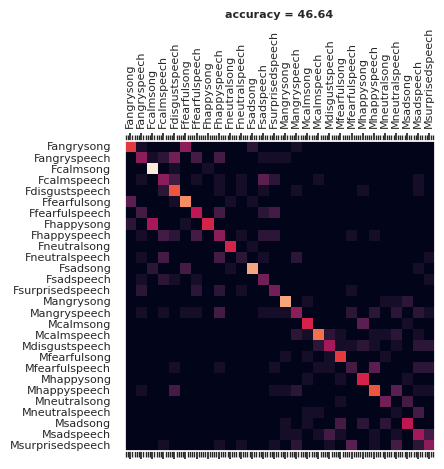

In [10]:
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(y[test_idxs], ypred))
plt.xticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=90);
plt.yticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=0);

plt.title(f"accuracy = {accuracy_score(y[test_idxs], ypred)*100:.2f}")
plt.grid(ls="")

## Tuning (for prediction of emotion only)

### Get labels

In [11]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
labels = df.emotion.to_numpy()
y = enc.fit_transform(labels)

### Split dataset

In [12]:
idxs = np.arange(len(df))
np.random.shuffle(idxs)
train_idxs, val_idxs, test_idxs = np.split(idxs, (len(df)*np.array([0.7, 0.8])).astype(int))

### Start the study

In [13]:
import optuna
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective(trial, train_idxs, val_idxs)
study.optimize(trial_function, n_trials=1, n_jobs=2, catch=ValueError)

[I 2023-07-02 13:00:14,102] A new study created in memory with name: no-name-bf30716d-caf5-4591-9036-0cf733445935


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [7, 7], 'conv_pool_sizes': [5, 4], 'n_dense_layers': 2, 'dense_nodes': 132} with SpRes = 115 for epochs = 15


2023-07-02 13:00:14.342612: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 208185120 exceeds 10% of free system memory.
[I 2023-07-02 13:00:44,413] Trial 0 finished with value: 0.46122448979591835 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 7, 'pool_1': 4, 'n_dense_layers': 2, 'dense_nodes': 132, 'batch_size': 20}. Best is trial 0 with value: 0.46122448979591835.


## Results

In [14]:
best_params_emotion = study.best_params.copy()

# Retrieves best parameters form the dict and saves them as a list
best_params_emotion["conv_filter_sizes"] = []
best_params_emotion["conv_kernel_sizes"] = []
best_params_emotion["conv_pool_sizes"] = []

for key in np.sort(list(study.best_params.keys())):
    if "filter" in key:
        best_params_emotion["conv_filter_sizes"].append(study.best_params[key])
    if "kernel" in key:
        best_params_emotion["conv_kernel_sizes"].append(study.best_params[key])
    if "pool" in key:
        best_params_emotion["conv_pool_sizes"].append(study.best_params[key])

print("for all-class best is", best_params_emotion)
        
        
        
X = STFT_dict[best_params_emotion["resolution"]]

cnn = build_model(X.shape[1:], len(np.unique(y)), **best_params_emotion)
cnn.summary()

# Train on train+validation
final_train_idxs = np.concatenate((train_idxs, val_idxs))

cnn.fit(X[final_train_idxs], 
        y[final_train_idxs], 
        epochs=best_params_emotion["epochs"], 
        batch_size=best_params_emotion["batch_size"])

for all-class best is {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 7, 'pool_1': 4, 'n_dense_layers': 2, 'dense_nodes': 132, 'batch_size': 20, 'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [7, 7], 'conv_pool_sizes': [5, 4]}
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv1D)             (None, 331, 14)           8834      
                                                                 
 avg_pooling_0 (AveragePooli  (None, 66, 14)           0         
 ng1D)                                                           
                                                                 
 conv_1 (Conv1D)             (None, 60, 15)            1485      
                                                                 
 flatten_2 (Flatten)         (None, 900)               0         
     

2023-07-02 13:00:45.109932: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 237908520 exceeds 10% of free system memory.


99/99 [==============================] - 4s 26ms/step - loss: 1.9785 - accuracy: 0.2060
Epoch 2/15
99/99 [==============================] - 3s 25ms/step - loss: 1.8580 - accuracy: 0.2453
Epoch 3/15
99/99 [==============================] - 3s 26ms/step - loss: 1.7435 - accuracy: 0.3274
Epoch 4/15
99/99 [==============================] - 3s 26ms/step - loss: 1.6029 - accuracy: 0.3763
Epoch 5/15
99/99 [==============================] - 3s 27ms/step - loss: 1.5279 - accuracy: 0.4258
Epoch 6/15
99/99 [==============================] - 2s 25ms/step - loss: 1.3100 - accuracy: 0.5074
Epoch 7/15
99/99 [==============================] - 3s 28ms/step - loss: 1.1377 - accuracy: 0.5854
Epoch 8/15
99/99 [==============================] - 3s 28ms/step - loss: 0.9104 - accuracy: 0.6588
Epoch 9/15
99/99 [==============================] - 3s 26ms/step - loss: 0.7396 - accuracy: 0.7190
Epoch 10/15
99/99 [==============================] - 3s 26ms/step - loss: 0.5906 - accuracy: 0.7817
Epoch 11/15
99/99 [=

In [15]:
from sklearn.metrics import accuracy_score

ypred = np.argmax(cnn.predict(X[test_idxs]), axis=1)

print(accuracy_score(y[test_idxs], ypred))

16/16 [==============================] - 0s 10ms/step
0.39918533604887985


              precision    recall  f1-score   support

       angry       0.50      0.41      0.45        69
        calm       0.49      0.48      0.48        84
     disgust       0.51      0.49      0.50        37
     fearful       0.30      0.26      0.27        70
       happy       0.38      0.38      0.38        72
     neutral       0.36      0.63      0.46        41
         sad       0.28      0.32      0.30        75
   surprised       0.52      0.35      0.42        43

    accuracy                           0.40       491
   macro avg       0.42      0.41      0.41       491
weighted avg       0.41      0.40      0.40       491



/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


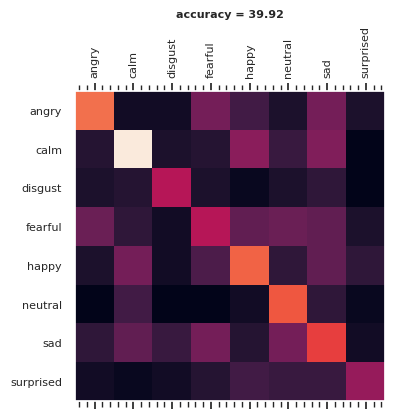

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

plt.matshow(confusion_matrix(y[test_idxs], ypred))
plt.xticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=90);
plt.yticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=0);

plt.title(f"accuracy = {accuracy_score(y[test_idxs], ypred)*100:.2f}")
plt.grid(ls="")

print(classification_report(enc.inverse_transform(y[test_idxs]), enc.inverse_transform(ypred)))

## Print filters

In [17]:
for layer in cnn.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)


conv_0 (7, 90, 14)
conv_1 (7, 14, 15)


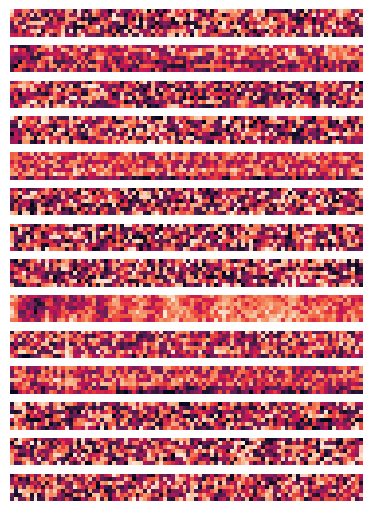

In [18]:
filters, biases = cnn.get_layer("conv_0").get_weights()

n_filters = filters.shape[-1]
fig, axes = plt.subplots(n_filters, 1, 
                         sharex=True, 
                         figsize=(10, 5), 
                         constrained_layout=True)
for i in range(n_filters):
    axes[i].axis("off")
    axes[i].matshow(filters[:,:,i])
